In [1]:
# Fix for module imports - add parent directory to Python path
import sys
import os

# Get the parent directory (project root) and add it to Python path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Added to Python path: {project_root}")
print("Now you can import from modules package!")


Added to Python path: /Users/josiasmoukpe/Desktop/sep-forecasting-research
Now you can import from modules package!


In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import psutil
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model

from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

from modules.training.cme_modeling import ModelBuilder as MB

In [3]:
from modules.training.phase_manager import TrainingPhaseManager

# instantiate the model_builder
mb = MB()
pm = TrainingPhaseManager()  # Training phase manager

In [4]:
def benchmark_function(func, args=(), kwargs=None, num_runs=100):
    """
    Generic benchmark utility for any function.
    
    :param func: Function to benchmark
    :param args: Tuple of positional arguments for the function
    :param kwargs: Dictionary of keyword arguments for the function
    :param num_runs: Number of runs for averaging timing
    :return: Dictionary containing timing and memory statistics
    """
    if kwargs is None:
        kwargs = {}
    global result
    process = psutil.Process(os.getpid())
    execution_times = []
    memory_usages = []

    # Warmup run
    _ = func(*args, **kwargs)

    # Clear any cached memory
    tf.keras.backend.clear_session()

    for _ in range(num_runs):
        mem_before = process.memory_info().rss / 1024 / 1024

        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()

        mem_after = process.memory_info().rss / 1024 / 1024

        execution_times.append(end_time - start_time)
        memory_usages.append(mem_after - mem_before)

        tf.keras.backend.clear_session()

    times_ms = np.array(execution_times) * 1000
    memory_mb = np.array(memory_usages)

    return {
        'time_mean_ms': np.mean(times_ms),
        'time_std_ms': np.std(times_ms),
        'memory_mean_mb': np.mean(memory_mb),
        'memory_max_mb': np.max(memory_mb),
        'last_result': result
    }

In [5]:
y_true = tf.constant([[1.0],
                      [5.0],
                      [0.0]])

z_pred = tf.constant([[1.0, 1.0],
                      [2.0, -1.0],
                      [3.0, 1.0]])

# create sample weights dictionary of label weights pairs
# Create dictionary mapping label values to weights
sample_weights = {
    1.0: 0.5,  # Weight for label 1.0
    5.0: 1.0,  # Weight for label 5.0 
    0.0: 0.8  # Weight for label 0.0
}

# print shapes
print(f"y_true shape: {y_true.shape}")
print(f"z_pred shape: {z_pred.shape}")

y_true shape: (3, 1)
z_pred shape: (3, 2)


In [6]:
res = mb.pds_loss_vec(y_true, z_pred, pm, train_sample_weights=sample_weights)
print(f'Result: {res.numpy():.4f}')

Result: 2.6891


In [7]:
res = mb.pds_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 3.9169


In [8]:
res = mb.pdc_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0293


In [9]:
res = mb.pdc_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0293


In [10]:
# Parameters
num_points = 5000  # 201 points for labels from -100 to 100 inclusive

# Create evenly spaced labels from -100 to 100
labels = np.linspace(-5000, 5000, num_points)
# update the dimension of labels
labels = np.expand_dims(labels, axis=1)

# Generate points like (0, 0), (1, 1), ..., (200, 200)
points = np.array([(i, i) for i in range(num_points)])

# convert to tensor float32
labels = tf.constant(labels, dtype=tf.float32)
points = tf.constant(points, dtype=tf.float32)

print(f"Labels shape: {labels.shape}")
print(f"Points shape: {points.shape}")

# Random sample weights between 0 and 1
sample_weights = np.random.rand(num_points)

Labels shape: (5000, 1)
Points shape: (5000, 2)


In [11]:
stats = benchmark_function(
    mb.pds_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 1432013.8750
Time: 64.439 ± 4.049 ms
Memory peak: 0.688 MB


In [12]:
stats = benchmark_function(
    mb.pds_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 1431728.1250
Time: 4.560 ± 0.307 ms
Memory peak: 0.297 MB


In [13]:
stats = benchmark_function(
    mb.pdc_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 0.0000
Time: 85.405 ± 3.831 ms
Memory peak: 0.078 MB


In [14]:
stats = benchmark_function(
    mb.pdc_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: -0.0000
Time: 5.519 ± 0.732 ms
Memory peak: 0.188 MB


In [15]:
class TrainerV4:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def generate_synthetic_data(self, num_points=200, noise_level=0.15):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        - noise_level controls the spread of the gaussian weighting (default 0.15)
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * noise_level ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, noise_level=0.15, verbose=1):
        # Generate synthetic data with specified noise level
        X_train, y_train = self.generate_synthetic_data(num_points=num_points, noise_level=noise_level)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")
        print(f"Noise Level Used: {noise_level}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step

Training Metrics:
Initial Loss: 1.044842
Final Loss: 0.000096
Convergence Threshold: 0.000731
Convergence Epoch: 97
Loss at Convergence: 0.000728
Time to Convergence: 3.01 seconds
Total Training Time: 14.96 seconds
Average Time per Batch: 5.67 ms
Final Correlation: 0.5093
Noise Level Used: 0.5
Final Pairwise Correlation: 0.5093


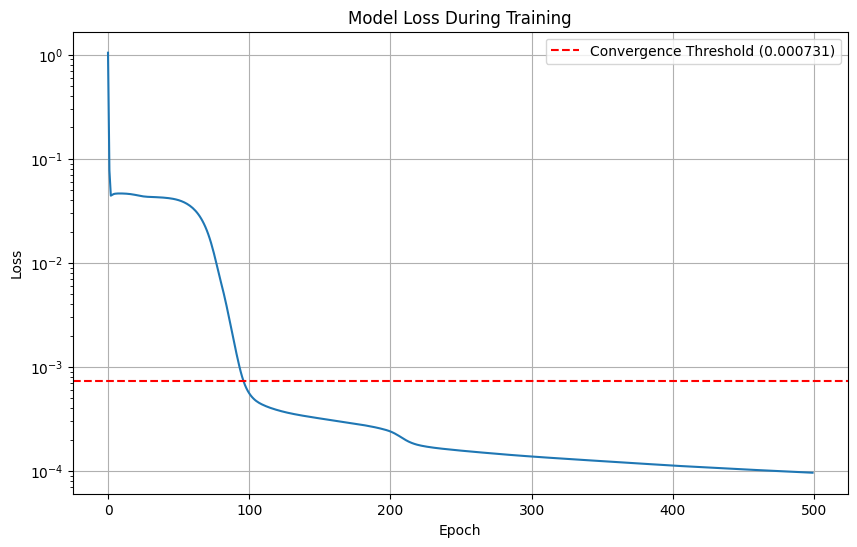

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


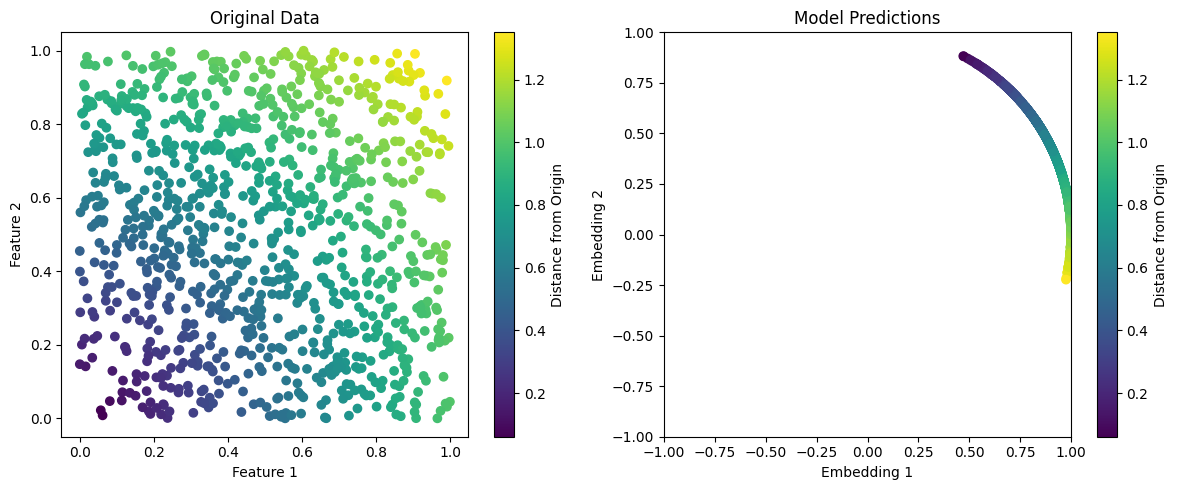

In [16]:
def custom_loss(y_true, y_pred):
    return mb.pds_sq_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.50
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000, 
    noise_level=noise_level,
    epochs=500, 
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step

Training Metrics:
Initial Loss: 0.064115
Final Loss: 0.000026
Convergence Threshold: 0.000045
Convergence Epoch: 153
Loss at Convergence: 0.000045
Time to Convergence: 5.07 seconds
Total Training Time: 8.85 seconds
Average Time per Batch: 6.47 ms
Final Correlation: 0.1513
Noise Level Used: 0.15
Final Pairwise Correlation: 0.1513


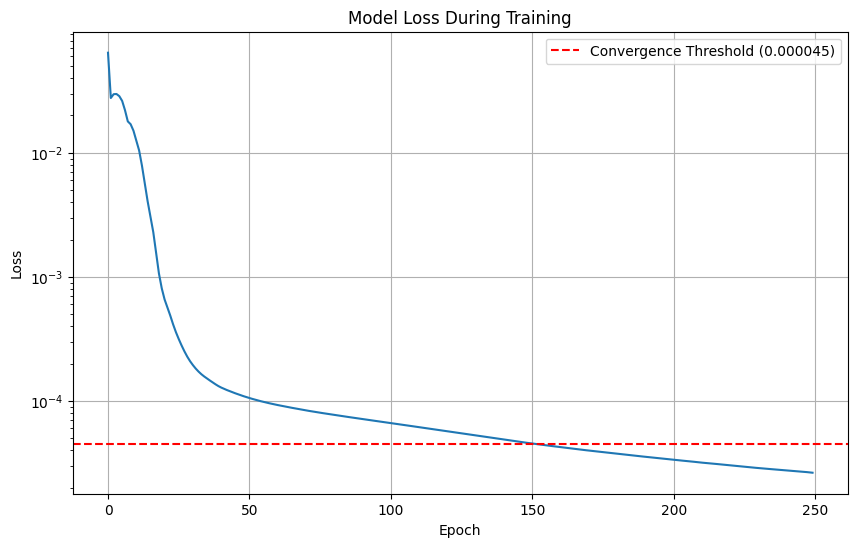

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


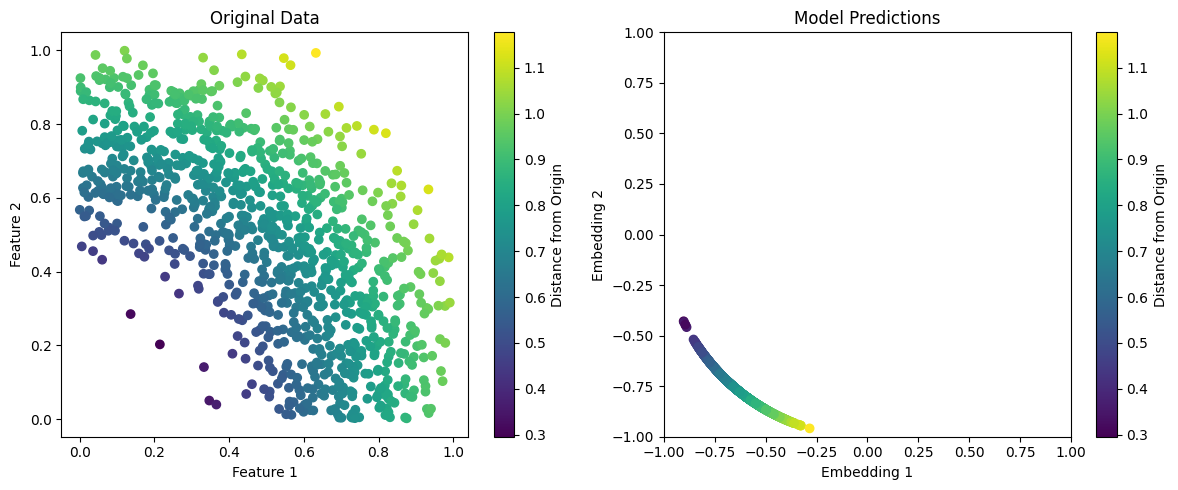

In [17]:
def custom_loss(y_true, y_pred):
    return mb.pds_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000, 
    noise_level=noise_level,
    epochs=250, 
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step

Training Metrics:
Initial Loss: 0.251941
Final Loss: 0.000051
Convergence Threshold: 0.000176
Convergence Epoch: 100
Loss at Convergence: 0.000174
Time to Convergence: 1.13 seconds
Total Training Time: 2.79 seconds
Average Time per Batch: 1.64 ms
Final Correlation: 0.1456
Noise Level Used: 0.15
Final Pairwise Correlation: 0.1456


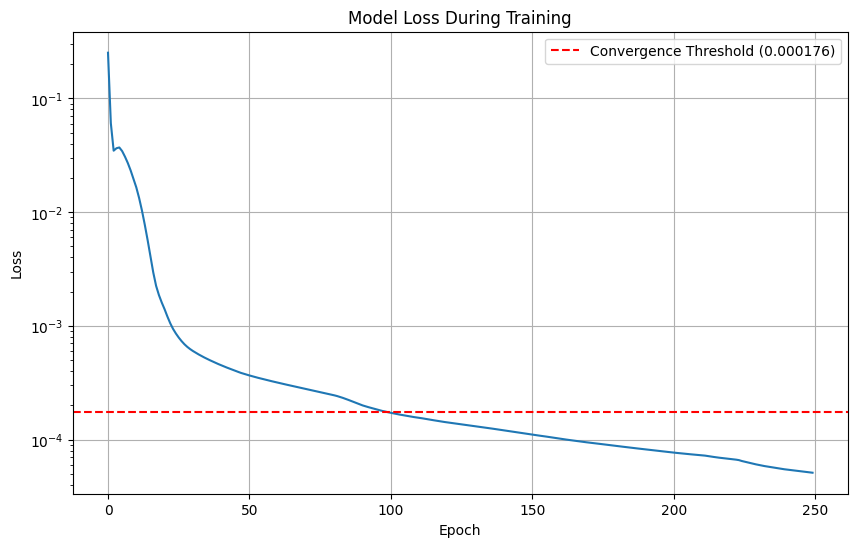

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


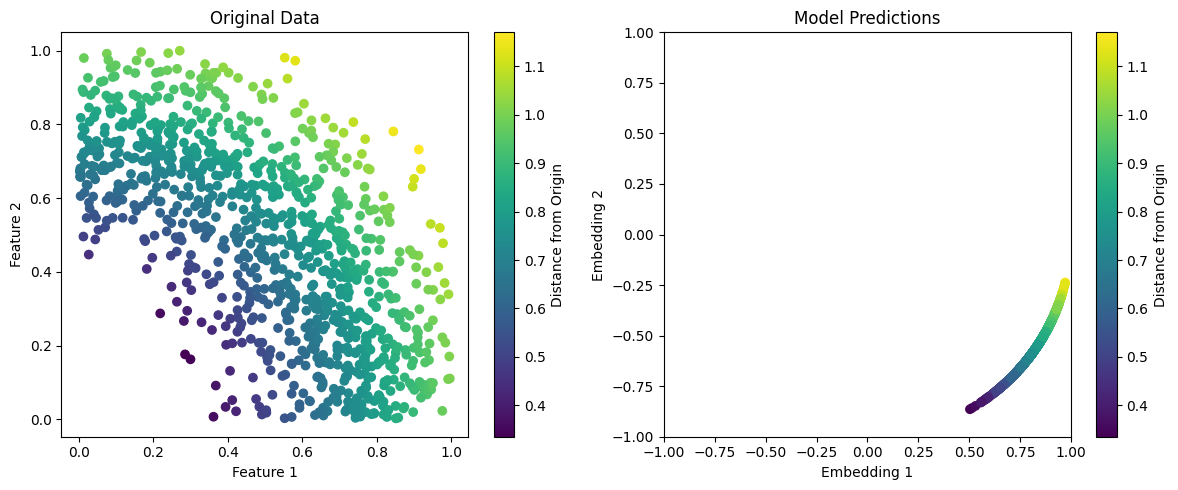

In [18]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000,
    noise_level=noise_level, 
    epochs=250,
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step

Training Metrics:
Initial Loss: 0.988726
Final Loss: 0.000951
Convergence Threshold: 0.000692
Model did not converge to threshold
Total Training Time: 2.72 seconds
Average Time per Batch: 1.58 ms
Final Correlation: 0.1500
Noise Level Used: 0.15
Final Pairwise Correlation: 0.1500


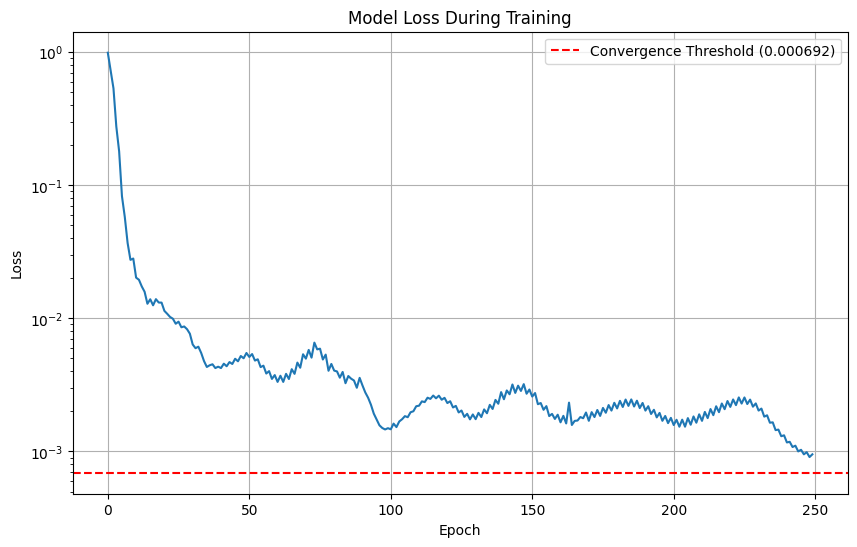

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


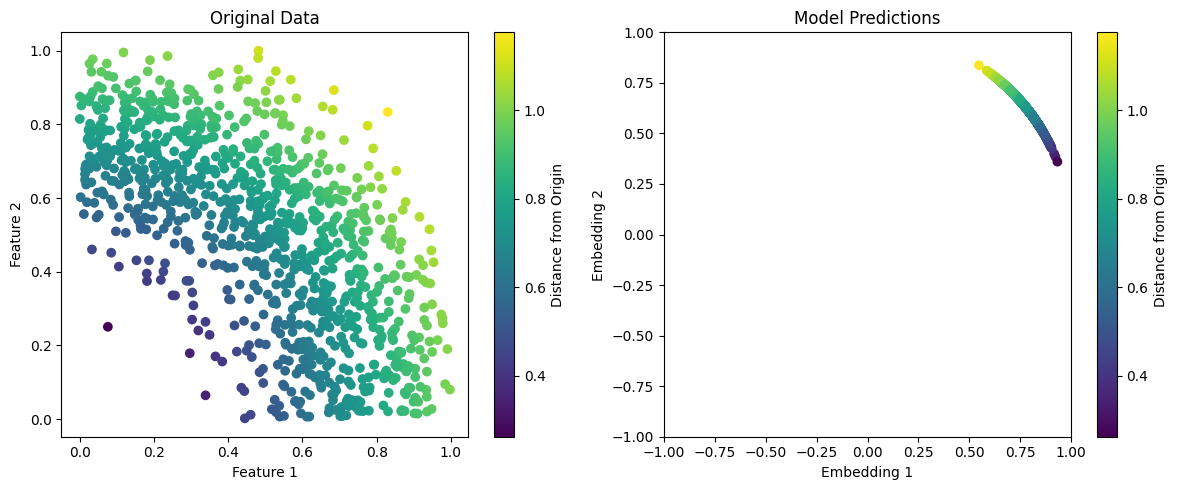

In [20]:

def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    noise_level=noise_level,
    epochs=250, 
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step

Training Metrics:
Initial Loss: 0.031038
Final Loss: 0.000004
Convergence Threshold: 0.000022
Convergence Epoch: 48
Loss at Convergence: 0.000022
Time to Convergence: 0.67 seconds
Total Training Time: 2.61 seconds
Average Time per Batch: 1.49 ms
Final Correlation: 0.1467
Noise Level Used: 0.15
Final Pairwise Correlation: 0.1467


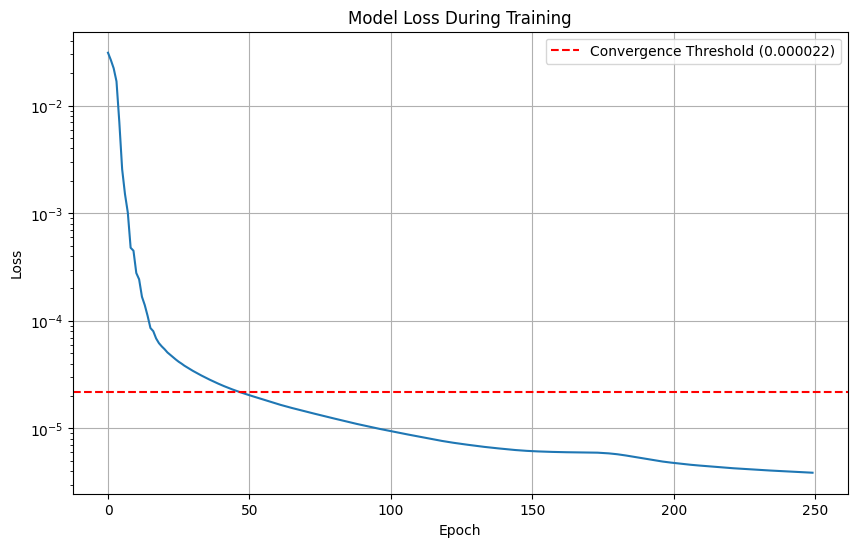

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


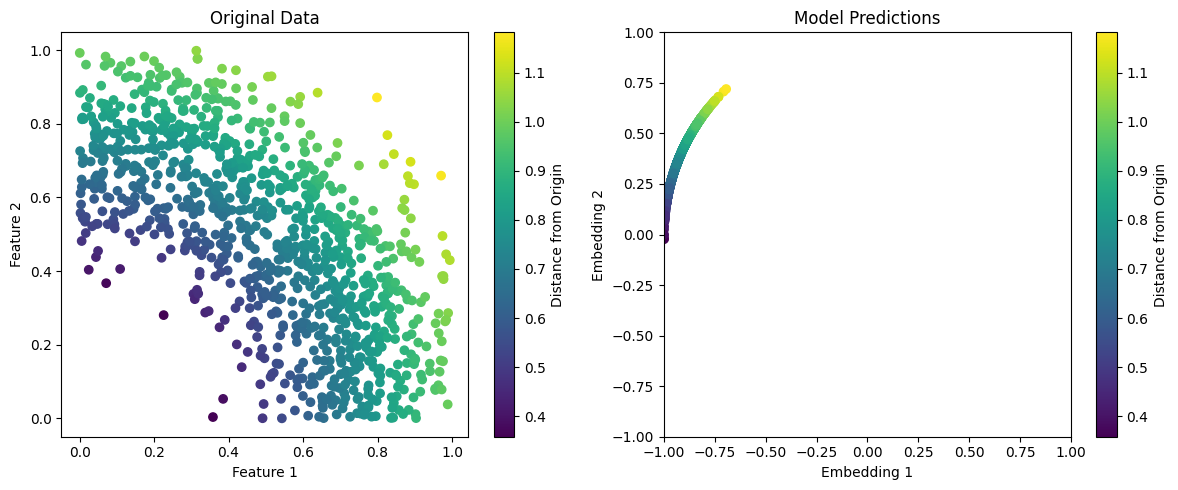

In [21]:
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_m_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    noise_level=noise_level,
    epochs=250, 
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step

Training Metrics:
Initial Loss: 0.894766
Final Loss: 0.000264
Convergence Threshold: 0.000626
Convergence Epoch: 87
Loss at Convergence: 0.000621
Time to Convergence: 0.93 seconds
Total Training Time: 2.61 seconds
Average Time per Batch: 1.50 ms
Final Correlation: 0.1460
Noise Level Used: 0.15
Final Pairwise Correlation: 0.1460


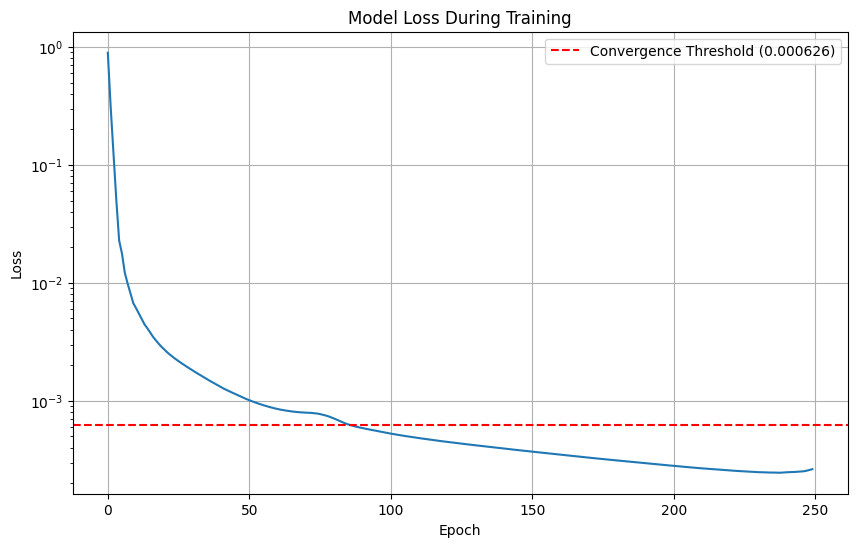

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


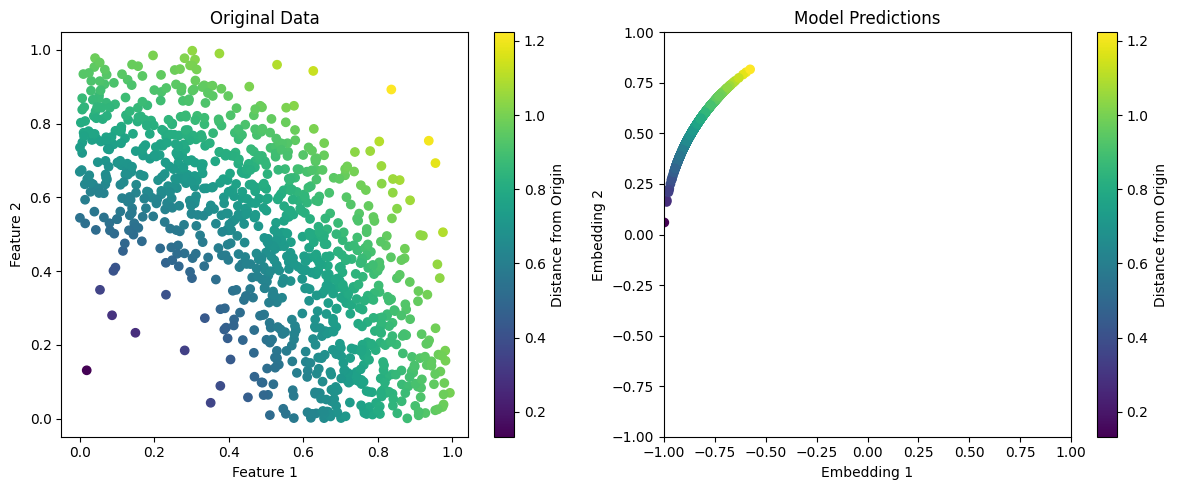

In [22]:
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_m_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    noise_level=noise_level,
    epochs=250, 
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [23]:
class TrainerV5:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, ae=False):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.ae = ae
        self.encoder_model = None
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer (Encoder output)
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)

        if not self.ae:
            model = Model(inputs=inputs, outputs=outputs)
            self.encoder_model = model
        else:
            # Build decoder
            decoder_x = outputs
            for dim in reversed(self.hidden_dims):
                decoder_x = Dense(dim)(decoder_x)
                decoder_x = LeakyReLU()(decoder_x)
            reconstructed = Dense(self.input_dim)(decoder_x)
            model = Model(inputs=inputs, outputs=[outputs, reconstructed])
            self.encoder_model = Model(inputs=inputs, outputs=outputs)

        return model

    def generate_synthetic_data(self, num_points=200):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, verbose=1, lambda_value=1.0):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=num_points)

        # Adjust targets for AE
        if self.ae:
            train_targets = (y_train, X_train)
        else:
            train_targets = y_train

        # Compile model
        if not self.ae:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=loss_fn
            )
        else:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=[loss_fn, 'mse'],
                loss_weights=[1.0, lambda_value]
            )

        # Convert to tf.data.Dataset
        if not self.ae:
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        else:
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (y_train, X_train)))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions using the encoder model
        predictions = self.encoder_model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step

Training Metrics:
Initial Loss: 1.012995
Final Loss: 0.056742
Convergence Threshold: 0.000709
Model did not converge to threshold
Total Training Time: 5.96 seconds
Average Time per Batch: 2.09 ms
Final Correlation: 0.1476
Final Pairwise Correlation: 0.1476


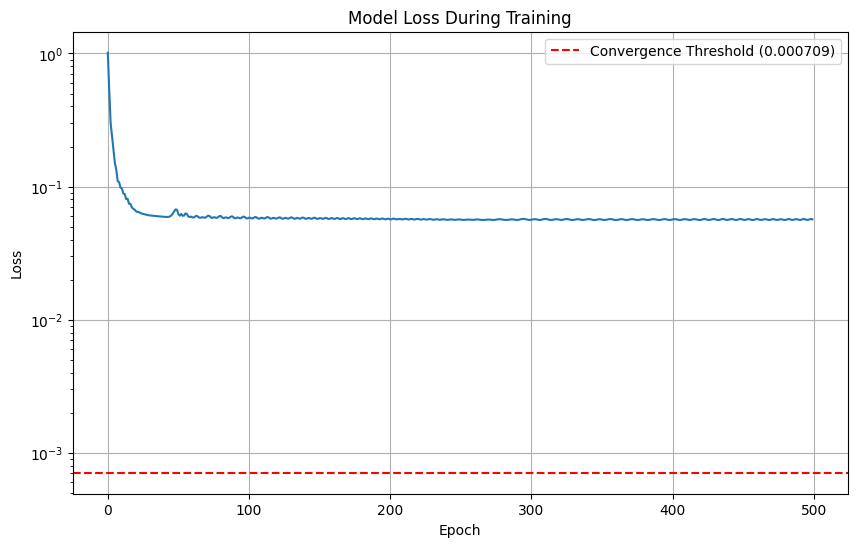

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


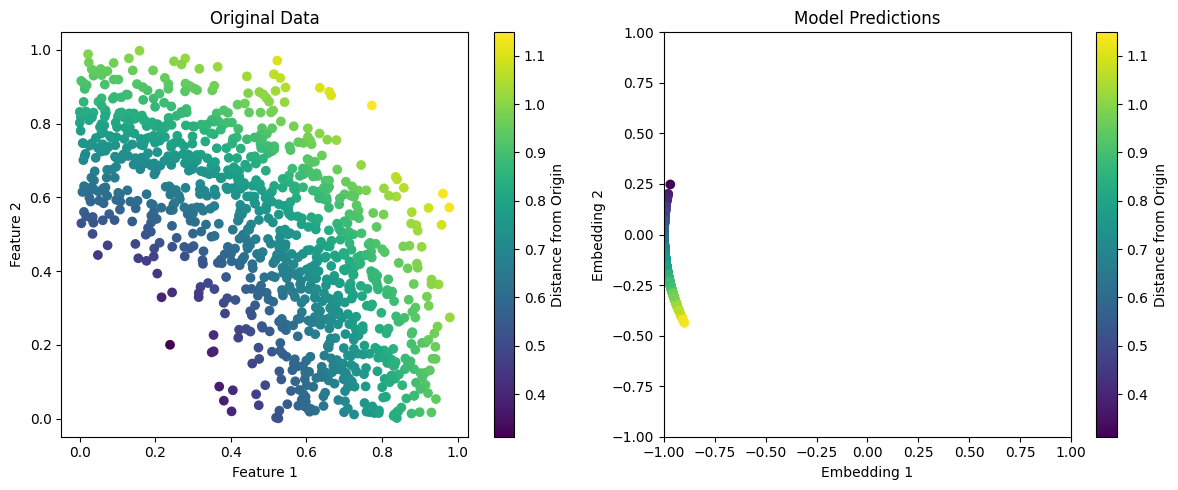

In [24]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


# Instantiate TrainerV5 with autoencoder enabled
trainer = TrainerV5(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=True)

# Train the model
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    epochs=500,
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Generate synthetic data for testing
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)

# Use the encoder model to get the embeddings
predictions = trainer.encoder_model.predict(X_test)

# Plot predictions
trainer.plot_predictions(X_test, y_test, predictions)


In [ ]:
import time
import numpy as np

# Define your custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_sq_loss_vec(y_true, y_pred, pm)  # Replace with your actual loss function

noise_level = 0.15
N = 5  # Number of trials

# Initialize lists to store metrics
epochs_to_converge_list = []
time_to_converge_list = []
loss_at_convergence_list = []
time_per_epoch_list = []
final_correlation_list = []

# Convergence criteria settings
convergence_criterion = 1e-4  # Threshold for change in loss
patience = 5  # Number of consecutive epochs to check for convergence

for trial in range(N):
    print(f"Starting trial {trial + 1}/{N}")
    
    # Instantiate the trainer
    trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
    
    # Generate synthetic data (if needed within the trainer)
    # X_train, y_train = trainer.generate_synthetic_data(num_points=5000, noise_level=noise_level)
    
    # Start timer
    start_time = time.perf_counter()
    
    # Train the model
    history, final_correlation = trainer.train(
        loss_fn=custom_loss,
        num_points=5000,
        noise_level=noise_level,
        epochs=500,
        batch_size=1024
    )
    
    # End timer
    end_time = time.perf_counter()
    total_time = end_time - start_time
    
    # Calculate time per epoch
    num_epochs = len(history.history['loss'])
    time_per_epoch = total_time / num_epochs
    
    # Determine epochs to converge and loss at convergence
    losses = history.history['loss']
    epochs_to_converge = num_epochs  # Default to total epochs if convergence not detected
    convergence_detected = False
    
    for i in range(patience, num_epochs):
        # Calculate the absolute differences in loss over the patience window
        loss_diffs = [abs(losses[j] - losses[j - 1]) for j in range(i - patience + 1, i + 1)]
        
        # Check if all differences are below the convergence criterion
        if all(diff < convergence_criterion for diff in loss_diffs):
            epochs_to_converge = i - patience + 1  # Adjust index to get the correct epoch number
            convergence_detected = True
            break  # Exit loop once convergence is detected
    
    # Get loss at convergence
    loss_at_convergence = losses[epochs_to_converge - 1]
    
    # Calculate time to converge
    time_to_converge = time_per_epoch * epochs_to_converge
    
    # Store metrics
    epochs_to_converge_list.append(epochs_to_converge)
    time_to_converge_list.append(time_to_converge)
    loss_at_convergence_list.append(loss_at_convergence)
    time_per_epoch_list.append(time_per_epoch)
    final_correlation_list.append(final_correlation)
    
    # Print results for the trial
    print(f"Trial {trial + 1}:")
    print(f"  Epochs to converge: {epochs_to_converge}")
    print(f"  Time to converge: {time_to_converge:.4f} seconds")
    print(f"  Loss at convergence: {loss_at_convergence:.6f}")
    print(f"  Time per epoch: {time_per_epoch:.6f} seconds")
    print(f"  Final Pairwise Correlation: {final_correlation:.4f}")
    print("-" * 50)

# Calculate averages
avg_epochs_to_converge = np.mean(epochs_to_converge_list)
avg_time_to_converge = np.mean(time_to_converge_list)
avg_loss_at_convergence = np.mean(loss_at_convergence_list)
avg_time_per_epoch = np.mean(time_per_epoch_list)
avg_final_correlation = np.mean(final_correlation_list)

# Print average results
print("\nAverage over {} trials:".format(N))
print(f"  Average epochs to converge: {avg_epochs_to_converge:.2f}")
print(f"  Average time to converge: {avg_time_to_converge:.4f} seconds")
print(f"  Average loss at convergence: {avg_loss_at_convergence:.6f}")
print(f"  Average time per epoch: {avg_time_per_epoch:.6f} seconds")
print(f"  Average Final Pairwise Correlation: {avg_final_correlation:.4f}")

# Optionally, plot training history and predictions from the last trial
# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)
